In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [ ]:
#import file
drive.mount('/content/drive') # uncomment when run locally

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mat = loadmat("/content/drive/My Drive/RUG/COIL20.mat") #change to local path when not using google colab

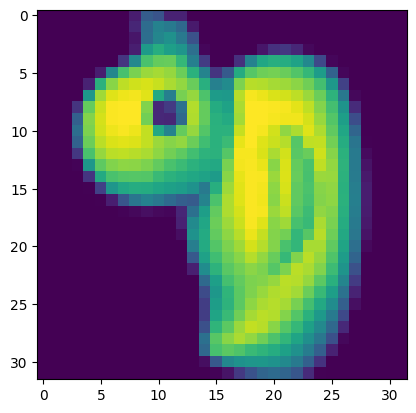

In [ ]:
#display image
from matplotlib import pyplot as plt
plt.imshow(image_matrix, interpolation='nearest')
plt.show()

In [ ]:
import logging
l = logging.getLogger()
l.setLevel(logging.ERROR)

In [ ]:
# X...data array[array]
# d...dimensionality of the projection
# return tuple (reduced data, fraction of total variance) or None
def PCA(X, d):
  # 1) centralize the data set Z = X − μ (μ is computed as the mean of all samples)
  mu = X.mean(axis=0)
  Z = X - mu
  n = len(Z[0])

  l.info(f"# measurements: {len(Z)}")
  l.info(f"# variables: n={n}")

  if d >= n:
    l.error(f"invalid parameter: cannot reduce from {n} to {d}")
    return None

  # 2) compute principal components U and eigen-values D using np.linalg.eig
  # principal component = eigen-vector of cov-matrix
  covariance_matrix = np.cov(Z, rowvar=False)

  # solve for all components U and their importance (eig-values)
  eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

  # 3) pick the first d principal components
  l.info(f"picking the first {d} principal components of {n} total")

  # create a list of tuples and sort descending by eigenvalues

  tuples = sorted( (
      (eigenvalues[i], eigenvectors[i]) for i in range(len(eigenvalues))
      ), key= lambda x: x[0], reverse=True );

  l.info(f"Principal components preview:")
  l.info(f"(lambda0, u0): {tuples[0]}")
  l.info(f"(lambda1, u1): {tuples[1]}")

  variance_contributions = [tup[0] for tup in tuples]
  U = np.transpose([tup[1] for tup in tuples]) # columns contain eigen-vectors
  U_d = U[:d]

  # information loss (fraction of total variance)
  p_d = np.sum(variance_contributions[:d]) / np.sum(variance_contributions)

  # 4) reduce the dimensionality of the data Z_d = U_d^T Z
  # project dataset into reduced space f(x) = U^T * x

  l.debug(f"len(U)={len(U_d)}")
  l.debug(f"len(U[0])={len(U_d[0])}")
  l.debug(f"len(Z)={len(Z)}")
  l.debug(f"len(Z[0])={len(Z[0])}")

  # m ... # measurements
  # project every point: [m x n] dot [n x d] = [m x d] dataset
  Z_d = np.dot(Z, np.transpose(U_d))

  return (Z_d, p_d)


In [ ]:
res = PCA(mat['X'], 100)

In [ ]:
f"p_d = {res[1]}"

In [ ]:
import matplotlib.pyplot as plt

reduced_data = res[0]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# scatter plot with three components
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c='b', marker='o', label='Data Points')

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Visualization (3 Components)')

# Add a legend if needed
ax.legend(loc='best')

# Show the 3D plot
plt.show()

In [ ]:
# EXCPERIMENTS SECTION

# X...data array[array]
# alpha... target information retention (0 < a < 1)
# return tuple (reduced data, fraction of total variance) or None
def PCA_threshold(X, alpha):
  # 1) centralize the data set Z = X − μ (μ is computed as the mean of all samples)

  mu = X.mean(axis=0)
  Z = ( X - mu )


  n = len(Z[0])
  l.info(f"# measurements: {len(Z)}")
  l.info(f"# variables: n={n}")

  if not (0 < alpha and alpha < 1 ):
    l.error("invalid threshold")
    return None

  # 2) compute principal components U and eigen-values D using np.linalg.eig
  # principal component = eigen-vector of cov-matrix
  covariance_matrix = np.cov(Z, rowvar=False)

  # solve for all components U and their importance (eig-values)
  eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

  # 3) pick the first d principal components

  # create a list of tuples and sort descending by eigenvalues

  tuples = sorted( (
      (eigenvalues[i], eigenvectors[i]) for i in range(len(eigenvalues))
      ), key= lambda x: x[0], reverse=True );

  l.info(f"Principal components preview:")
  l.info(f"(lambda0, u0): {tuples[0]}")
  l.info(f"(lambda1, u1): {tuples[1]}")

  variance_contributions = [tup[0] for tup in tuples]
  U = np.transpose([tup[1] for tup in tuples]) # columns contain eigen-vectors

  # calculate number of reduced dimensions based on targeted fraction of total variance

  d = -1
  p_d = -1

  for i in range(n):
    p_i = np.sum(variance_contributions[:i]) / np.sum(variance_contributions) # fraction of total variance
    if(p_i >= alpha):
      d = i
      p_d = p_i
      break
  if d==-1 or p_d==-1:
    print("fraction total variance calculation failed")
    return None

  U_d = U[:d]


  # 4) reduce the dimensionality of the data Z_d = U_d^T Z
  # project dataset into reduced space f(x) = U^T * x

  l.debug(f"len(U)={len(U_d)}")
  l.debug(f"len(U[0])={len(U_d[0])}")
  l.debug(f"len(Z)={len(Z)}")
  l.debug(f"len(Z[0])={len(Z[0])}")

  # m ... # measurements
  # project every point: [m x n] dot [n x d] = [m x d] dataset
  Z_d = np.dot(Z, np.transpose(U_d))

  return (Z_d, p_d, d)

In [ ]:
alpha=0.9
reduced, pd, d = PCA_threshold(mat['X'], alpha)
print(f"target alpha= {alpha}, solution alpha= {pd}, solution dimensionality={d}")

alpha=0.95
reduced, pd, d = PCA_threshold(mat['X'], alpha)
print(f"target alpha= {alpha}, solution alpha= {pd}, solution dimensionality={d}")

alpha=0.98
reduced, pd, d = PCA_threshold(mat['X'], alpha)
print(f"target alpha= {alpha}, solution alpha= {pd}, solution dimensionality={d}")


In [ ]:
# eigen-value profile
from matplotlib import collections as matcoll

def getEigenProfile(X):
  mu = X.mean(axis=0)
  std_dev = X.std(axis=0)
  Z = ( X - mu ) / std_dev
  n = len(Z[0])
  covariance_matrix = np.cov(Z, rowvar=False)
  eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
  indices = np.arange(1, len(eigenvalues)+1)

  return (indices, eigenvalues)


indices, eigenvalues = getEigenProfile(mat['X'])



# plot full
vlines = []
for i in range(len(indices)):
    pair=[(indices[i],0), (indices[i], eigenvalues[i])]
    vlines.append(pair)

linecoll = matcoll.LineCollection(vlines)
fig, ax = plt.subplots()
ax.add_collection(linecoll)
plt.scatter(x=indices, y=eigenvalues)

plt.xlabel('Index of Eigenvalue')
plt.ylabel('Eigenvalue')
plt.title('2D visualization of eigenvalue profile Full')
plt.show()

# plot zoom
i = 50

linecoll = matcoll.LineCollection(vlines[:i])
fig, ax = plt.subplots()
ax.add_collection(linecoll)
plt.scatter(x=indices[:i], y=eigenvalues[:i])

plt.xlabel('Index of Eigenvalue')
plt.ylabel('Eigenvalue')
plt.title('Zoomed 2D visualization of eigenvalue profile')
plt.show()


In [ ]:
import sklearn.manifold
reduced = PCA(mat['X'],40)[0]
X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(reduced)

fig = plt.figure(figsize=(10, 8))
plot = fig.add_subplot()
color_arr = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
for i in range(20):
  plot.scatter(X_embedded[(i*71):(i*71)+71, 0], X_embedded[(i*71):(i*71)+71, 1], c=color_arr[i], marker='o', label='Data Points')
plot.set_xlabel('X')
plot.set_ylabel('Y')
plt.show()


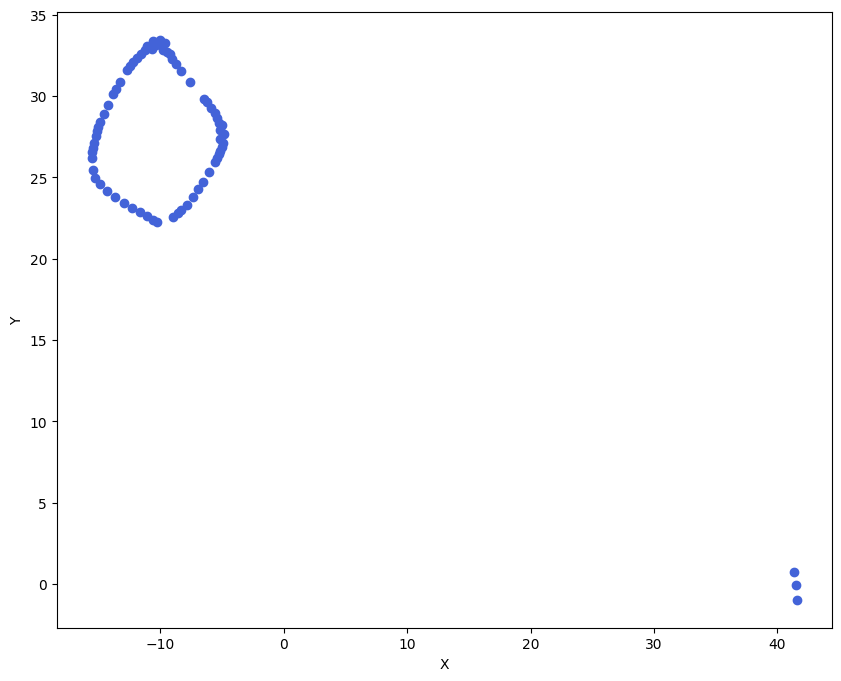

In [57]:
# find one cluster by manully increasing the index
fig = plt.figure(figsize=(10, 8))
plot = fig.add_subplot()
color_arr = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
for i in [3]:
  plot.scatter(X_embedded[(i*71):(i*71)+71, 0], X_embedded[(i*71):(i*71)+71, 1], c=color_arr[i], marker='o', label='Data Points')
plot.set_xlabel('X')
plot.set_ylabel('Y')
plt.show()

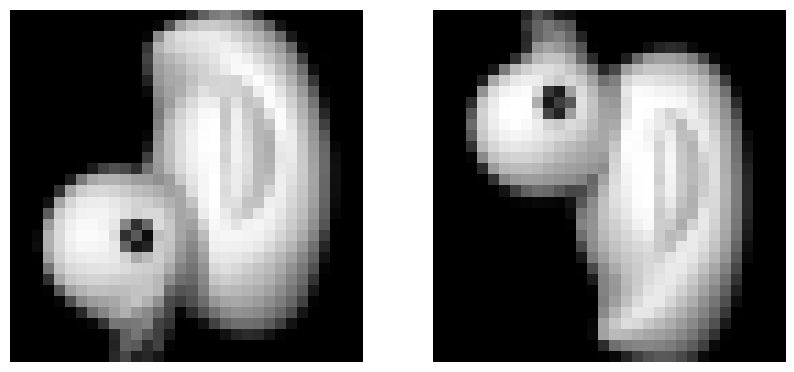

In [62]:
objectIndex = 3

cluster_centers = [[-10,33], [40,0]]

plt.figure(figsize=(10, 5))
# display original images at cluster_centers of object side by side
for i, center in enumerate(cluster_centers):
    plt.subplot(1, len(cluster_centers), i + 1)
    plt.imshow(mat['X'][np.argmin(np.linalg.norm(X_embedded - center, axis=1)[objectIndex*71 : objectIndex*71+71])].reshape(32,32), cmap='gray')
    plt.axis('off')

plt.show()